In [ ]:
!pip install transformers
!pip install accelerate


In [2]:
# BERT Training and Evaluation Script for Google Colab

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch

In [11]:
# Form variable for choosing experiment
bert_experiment = "2 - RJP_train" # @param ["2 - RJP_train", "5 - davinci-003", "6 - FWV", "8 - Augmented"]

def experiment_value_url(argument):
    match argument:
        case '2 - RJP_train':
            return "RJP_train_60.csv"
        case '5 - davinci-003':
            return "davinci-003_dataset.csv"
        case '6 - FWV':
            return "FWV_dataset.csv"
        case '8 - Augmented':
            return "augmented_dataset.csv"
        case default:
            return "Invalid input"

print(experiment_value_url(bert_experiment))

# Load datasets from Google Drive or uploaded files
data_path = "./"  # Update this path if needed
real_data = pd.read_csv(data_path + experiment_value_url(bert_experiment), delimiter=";")
real_data_reminder = pd.read_csv(data_path + "RJP_evaluation.csv", delimiter=";")

class JobTitlesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }




RJP_train_60.csv


In [10]:
# Print the number of occurrences of each class for all datasets
datasets = {
    "Real Data": real_data,
    "Real Data Reminder": real_data_reminder
}

class_counts = {}
for dataset_name, dataset in datasets.items():
    class_counts[dataset_name] = dataset["title"].value_counts()

print(class_counts)

{'Real Data': Cook                        300
Teachers                    299
Human resources             299
Marketing                   298
Customer support - Sales    297
Retail services             297
Logistics                   296
Financial services          295
Civil Engineer              290
Landscaping - workers       283
Technicians                 281
Systems Engineer            280
Doctor                      280
Frontend developer          280
Application Developer       280
Spa Therapist               280
Pharmacist                  280
Software Architect          280
Lawyer                      275
Barman                      272
Hotel Manager               272
Receptionist                272
Restaurant Manager          272
Chambermaid                 272
Web developer               266
Nurse                       219
Lifeguard                   200
Trainee-junior lawyer       175
Name: title, dtype: int64, 'Real Data Reminder': Cook                        200
Teachers 

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import seaborn as sns
import matplotlib.pyplot as plt


# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    """Plots a confusion matrix using seaborn's heatmap()."""
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


def train_and_evaluate(train_data, test_data):
    # Split the train_data into training and evaluation datasets
    train_data, eval_data = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data["title"])
    train_data = train_data.reset_index(drop=True)
    eval_data = eval_data.reset_index(drop=True)


    # Define the BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(np.unique(train_data["title"])))

    # Prepare data
    train_dataset = JobTitlesDataset(train_data["jobPost"], train_data["title"].astype('category').cat.codes, tokenizer, 256)
    eval_dataset = JobTitlesDataset(eval_data["jobPost"], eval_data["title"].astype('category').cat.codes, tokenizer, 256)

    # Define the training arguments
    training_args = TrainingArguments(
        output_dir='./',
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        logging_dir='./logs',
        logging_steps=10,
        do_train=True,
        do_eval=True,
        no_cuda=False,
        load_best_model_at_end=True,
        eval_steps=50,
        evaluation_strategy="steps"
    )

    # Define the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

    # Train and evaluate
    trainer.train()
    results = trainer.evaluate()

    # Predictions on the provided test_data
    test_dataset = JobTitlesDataset(test_data["jobPost"], test_data["title"].astype('category').cat.codes, tokenizer, 256)
    predictions, labels, _ = trainer.predict(test_dataset)
    preds = np.argmax(predictions, axis=1)

    # Accuracy
    accuracy = accuracy_score(labels, preds)

    # Confusion Matrix
    conf_matrix = confusion_matrix(labels, preds)

    # Plot confusion matrix
    class_names = np.unique(test_data["title"]).tolist()
    plot_confusion_matrix(conf_matrix, class_names)

    # confusion matrix to excel
    df_conf_matrix = pd.DataFrame(conf_matrix, class_names, class_names)
    df_conf_matrix.to_excel('cm_job-posts_eval.xlsx')

    # print metrics by class using classification report.
    print(classification_report(labels, preds))

    return accuracy, conf_matrix


### Evaluate with explicit dataset

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
50,2.865700,2.592733
100,1.534200,1.318408
150,0.665700,0.500166
200,0.226300,0.173244
250,0.085500,0.057724
300,0.040700,0.026981
350,0.024300,0.017184
400,0.044400,0.013794
450,0.014700,0.010397
500,0.012300,0.008552


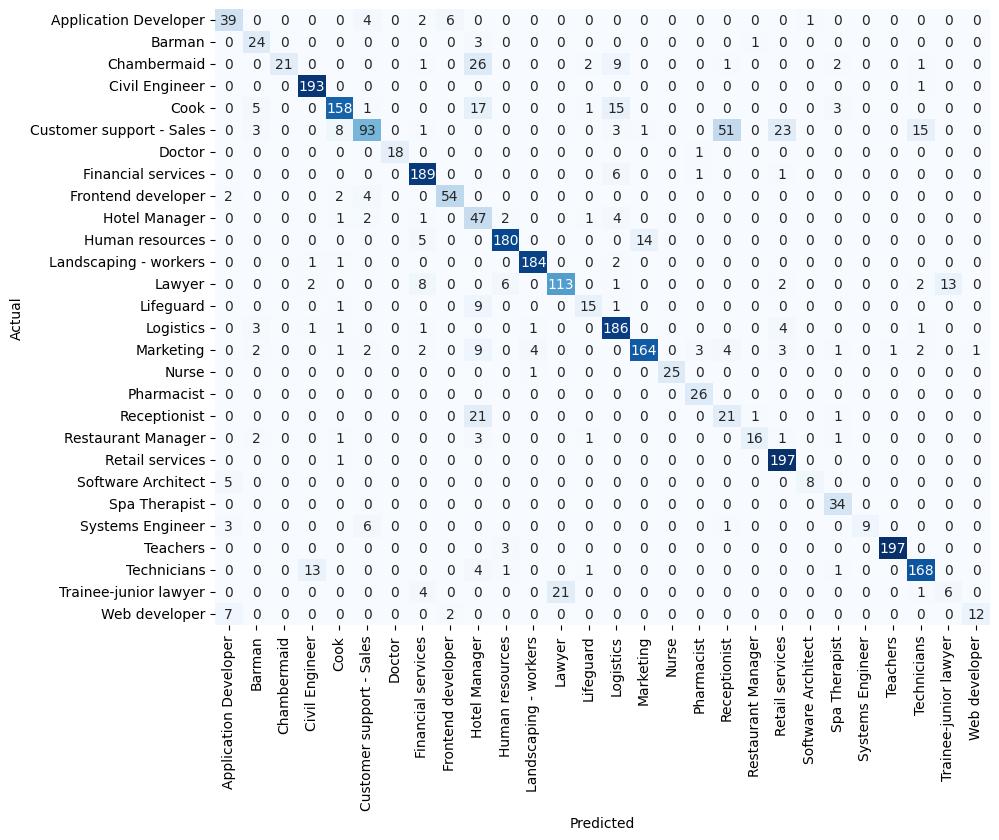

              precision    recall  f1-score   support

           0       0.70      0.75      0.72        52
           1       0.62      0.86      0.72        28
           2       1.00      0.33      0.50        63
           3       0.92      0.99      0.96       194
           4       0.90      0.79      0.84       200
           5       0.83      0.47      0.60       198
           6       1.00      0.95      0.97        19
           7       0.88      0.96      0.92       197
           8       0.87      0.87      0.87        62
           9       0.34      0.81      0.48        58
          10       0.94      0.90      0.92       199
          11       0.97      0.98      0.97       188
          12       0.84      0.77      0.80       147
          13       0.71      0.58      0.64        26
          14       0.82      0.94      0.88       198
          15       0.92      0.82      0.87       199
          16       1.00      0.96      0.98        26
          17       0.84    

In [ ]:
# Scenarios with simple Learning Rate implementation
scenarios = {
    "Real data 60 Train - Eval": (real_data, real_data_reminder)
}

# Execute scenarios
for scenario, (train_data, test_data) in scenarios.items():
    accuracy, conf_matrix = train_and_evaluate(train_data, test_data)
    print(f"Scenario: {scenario}")
    print(f"Accuracy: {accuracy}")
